In [1]:
import os
import sys

from utils import get_round_loss_score, train_one_epoch_output

sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns

import torch
import torch.nn as nn
import random

from src.Metamodel.data.dataloader import create_train_val_loader
from src.Metamodel.models.depthwiseNet import DepthNet

import torch.backends.cudnn as cudnn

from sklearn.metrics import confusion_matrix, auc, roc_auc_score, f1_score, classification_report, cohen_kappa_score
from torchmetrics.classification import MulticlassAUROC

import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed_all(0)

/home/moonsh/miniconda3/envs/sleep/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATAPATH = "../data/new"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DepthNet(lengths=30, patch_size=30, in_chans=2, embed_dim=256, norm_layer=None, output_dim=3).to(device)

weightType = "macro" # macro weighted

DepthNet is used...


In [3]:
epochs = 10
batch_size = 256
want_round = 5

In [4]:
local_train_results = []
local_test_results = []

In [5]:
for client_idx in range(1,11):

    print(f"Client {client_idx}")

    torch.manual_seed(0)
    train_set, validation_set = create_train_val_loader(DATAPATH, batch_size, length=30,
                                                        meta_train_client_idx_lst=[client_idx], FLtrain=True)
    
    if type(client_idx) == list:
        train = train_set

    else:
        train, test = torch.utils.data.random_split(train_set, 
                                                    [int(len(train_set)*0.8), len(train_set)-int(len(train_set)*0.8)],
                                                    generator=torch.Generator().manual_seed(0))
        
    if type(client_idx) == list:
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
        
    else:
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
        valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
        
    print("------------------------------------------------------")
    print("Train", len(train))
    print("Test", len(test))
    print("Total", len(train)+len(test))
    print("------------------------------------------------------")

    model = DepthNet(lengths=30, patch_size=30, in_chans=2, embed_dim=256, norm_layer=None, output_dim=3).to(device)

    lr = 0.0001

    optimizer_outer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer_outer, step_size=40, gamma=0.5, last_epoch=-1, verbose=False)
    criterion = nn.CrossEntropyLoss().to(device)

    best_acc = 0
    best_f1 = 0
    best_auc = 0
    auroc = MulticlassAUROC(num_classes=3, average=weightType).to(device)

    finish = False
    early_epoch = 1
    train_result_dic = {"loss": [], "acc": [], "f1": [], "auc": [], "confusion_matrix": []}
    test_result_dic = {"loss": [], "acc": [], "f1": [], "auc": [], "confusion_matrix": []}

    for epoch in range(epochs):
        epoch += 1
        model.train()
        running_loss = 0.0
        correct = 0

        train_pred = []
        train_real = []
        train_proba = []
        
        for data in train_loader:            
            x_data, stage = data[0].to(device), data[1].to(device)
            
            pred_value, _ = model(x_data)
            pred = torch.argmax(pred_value, dim=1)
            pred_proba = torch.sigmoid(pred_value)

            correct += torch.sum(pred==stage).item()

            train_pred.extend(pred.detach().cpu().numpy())
            train_real.extend(stage.detach().cpu().numpy())
            train_proba.extend(pred_proba.detach().cpu().numpy())

            loss = criterion(pred_value, stage)

            optimizer_outer.zero_grad()
            loss.backward()
            optimizer_outer.step()
            
            running_loss += loss.item()
        
        auc = auroc(torch.tensor(train_proba), torch.tensor(train_real))
        acc = correct / len(train_loader.dataset)
        running_loss /= len(train_loader)
        f1score = f1_score(train_real, train_pred, average=weightType)

        scheduler.step()

        train_result_dic["loss"].append(running_loss)
        train_result_dic["acc"].append(acc)
        train_result_dic["f1"].append(f1score)
        train_result_dic["auc"].append(auc.numpy())
        train_result_dic["confusion_matrix"].append(confusion_matrix(train_pred, train_real))
        
        if epoch % 1 == 0:

            correct = 0
            valid_loss = 0.0
            
            model.eval()

            val_pred = []
            val_real = []
            val_proba = []

            with torch.no_grad():
                for data in test_loader: # valid_loader
                    x_data, stage = data[0].to(device), data[1].to(device)
                    
                    # pred_value, _ = model(x_data)
                    pred_value, _ = model(x_data)
                    pred = torch.argmax(pred_value, dim=1)
                    pred_proba = torch.sigmoid(pred_value)

                    correct += torch.sum(pred==stage).item()

                    val_pred.extend(pred.detach().cpu().numpy())
                    val_real.extend(stage.detach().cpu().numpy())
                    val_proba.extend(pred_proba.detach().cpu().numpy())

                    loss = criterion(pred_value, stage)
                    valid_loss += loss.item()
                
                auc = auroc(torch.tensor(val_proba), torch.tensor(val_real))
                acc = correct / len(test_loader.dataset) # valid_loader.dataset
                valid_loss /= len(test_loader) # valid_loader
                f1score = f1_score(val_real, val_pred, average=weightType)            
                    
                if best_f1 < f1score:
                    best_f1 = f1score
                    best_epoch = epoch

                test_result_dic["loss"].append(valid_loss)
                test_result_dic["acc"].append(acc)
                test_result_dic["f1"].append(f1score)
                test_result_dic["auc"].append(auc.numpy())
                test_result_dic["confusion_matrix"].append(confusion_matrix(val_pred, val_real))

    local_train_results.append(train_result_dic)
    local_test_results.append(test_result_dic)
    print("###############################################################")

Client 1
------------------------------------------------------
Train 441
Test 111
Total 552
------------------------------------------------------
DepthNet is used...


/tmp/ipykernel_30042/2357481993.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352465323/work/torch/csrc/utils/tensor_new.cpp:201.)
  auc = auroc(torch.tensor(train_proba), torch.tensor(train_real))


###############################################################
Client 2
------------------------------------------------------
Train 377
Test 95
Total 472
------------------------------------------------------
DepthNet is used...
###############################################################
Client 3
------------------------------------------------------
Train 782
Test 196
Total 978
------------------------------------------------------
DepthNet is used...
###############################################################
Client 4
------------------------------------------------------
Train 716
Test 180
Total 896
------------------------------------------------------
DepthNet is used...
###############################################################
Client 5
------------------------------------------------------
Train 756
Test 189
Total 945
------------------------------------------------------
DepthNet is used...
###############################################################
Client 6


In [6]:
local_result = [local_train_results, local_test_results]

In [7]:
clients_results_meta = []

MODE = "meta" # "meta", "normal", "random"
MODELPATH = f"../src/FedMeta/model_file_cache/{MODE}"

for client in range(1,11):
    train_result, test_result = get_round_loss_score(DATAPATH, MODELPATH, model, device, client, weightedType=weightType, want_round=want_round)
    
    clients_results_meta.append([train_result, test_result])

In [8]:
clients_results_normal = []

MODE = "normal" # "meta", "normal", "random"
MODELPATH = f"../src/FedMeta/model_file_cache/{MODE}"

for client in range(1,11):
    train_result, test_result = get_round_loss_score(DATAPATH, MODELPATH, model, device, client, weightedType=weightType, want_round=want_round)
    
    clients_results_normal.append([train_result, test_result])

In [9]:
clients_results_random = []

MODE = "random" # "meta", "normal", "random"
MODELPATH = f"../src/FedMeta/model_file_cache/{MODE}"

for client in range(1,11):
    train_result, test_result = get_round_loss_score(DATAPATH, MODELPATH, model, device, client, weightedType=weightType, want_round=want_round)
    
    clients_results_random.append([train_result, test_result])

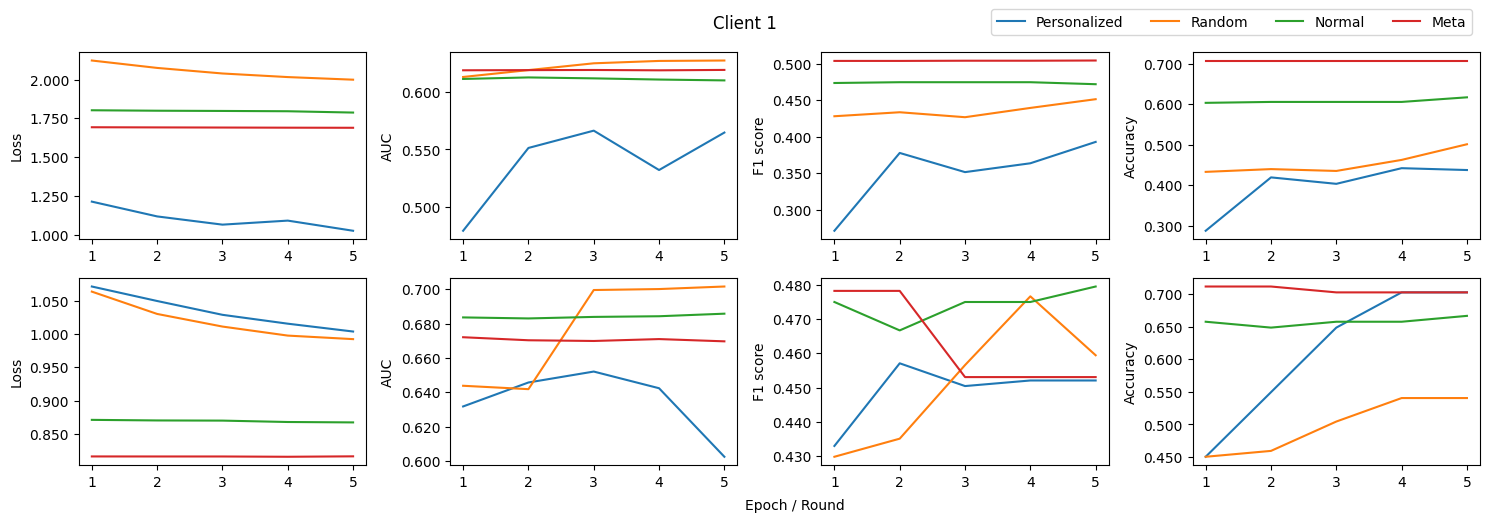

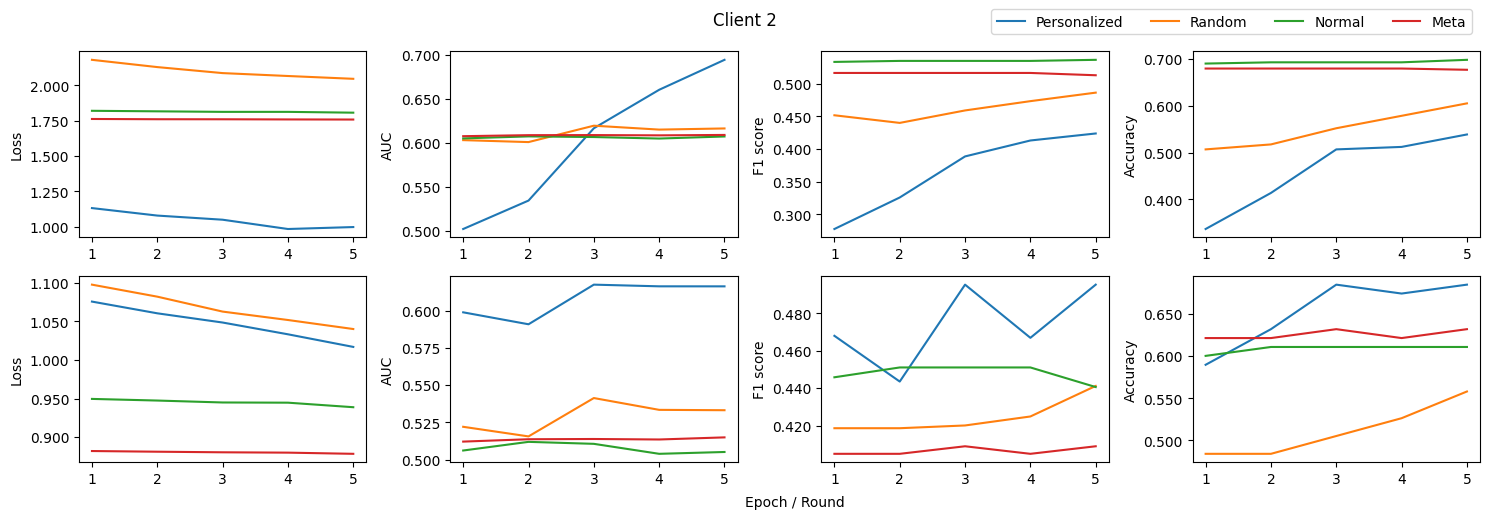

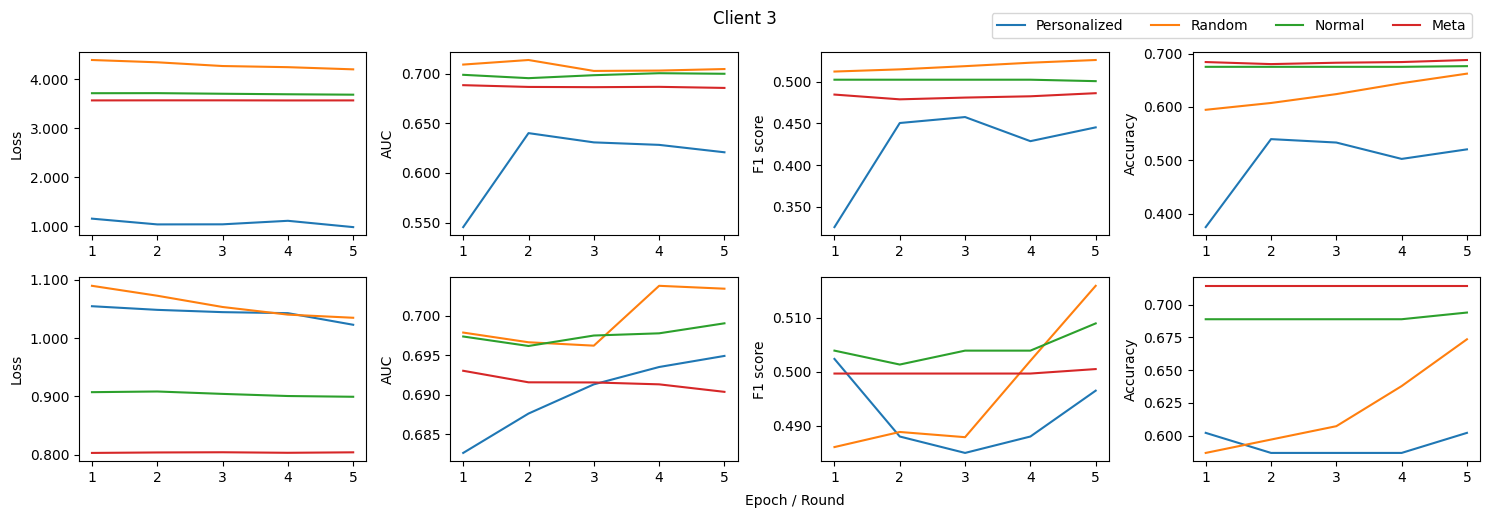

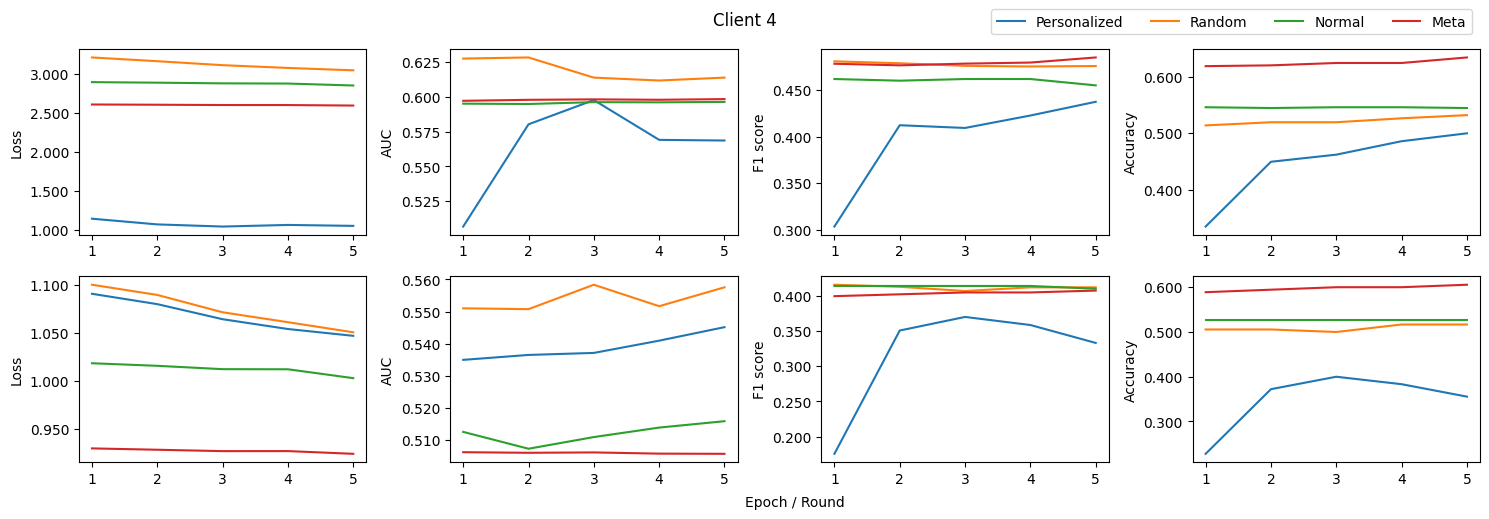

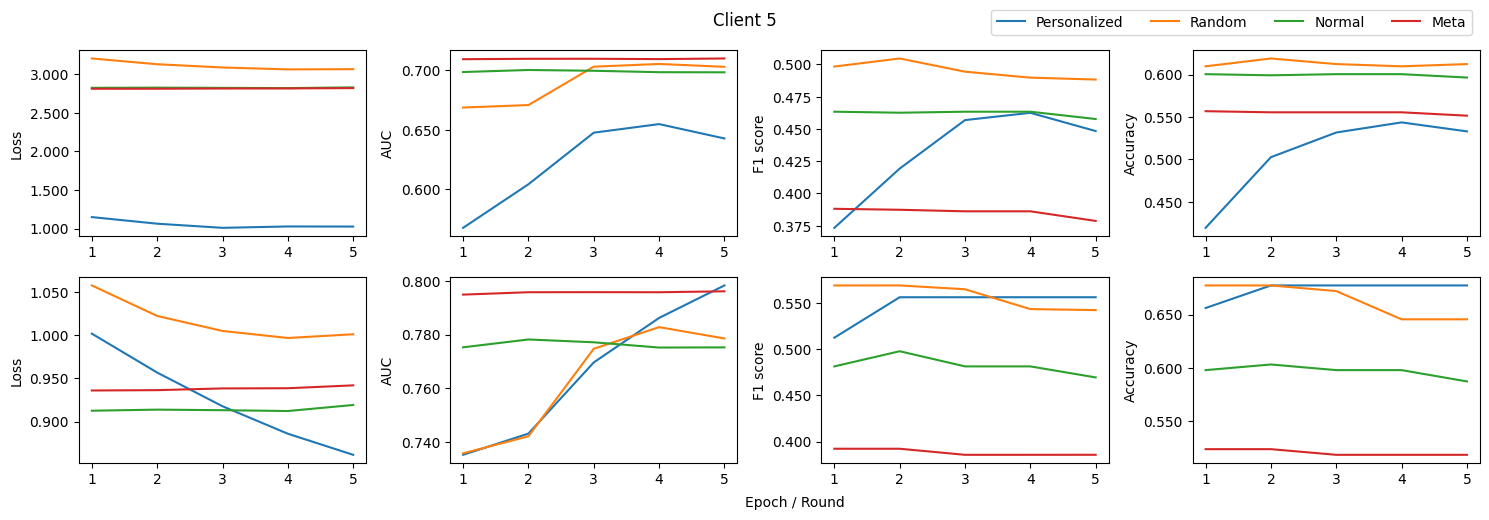

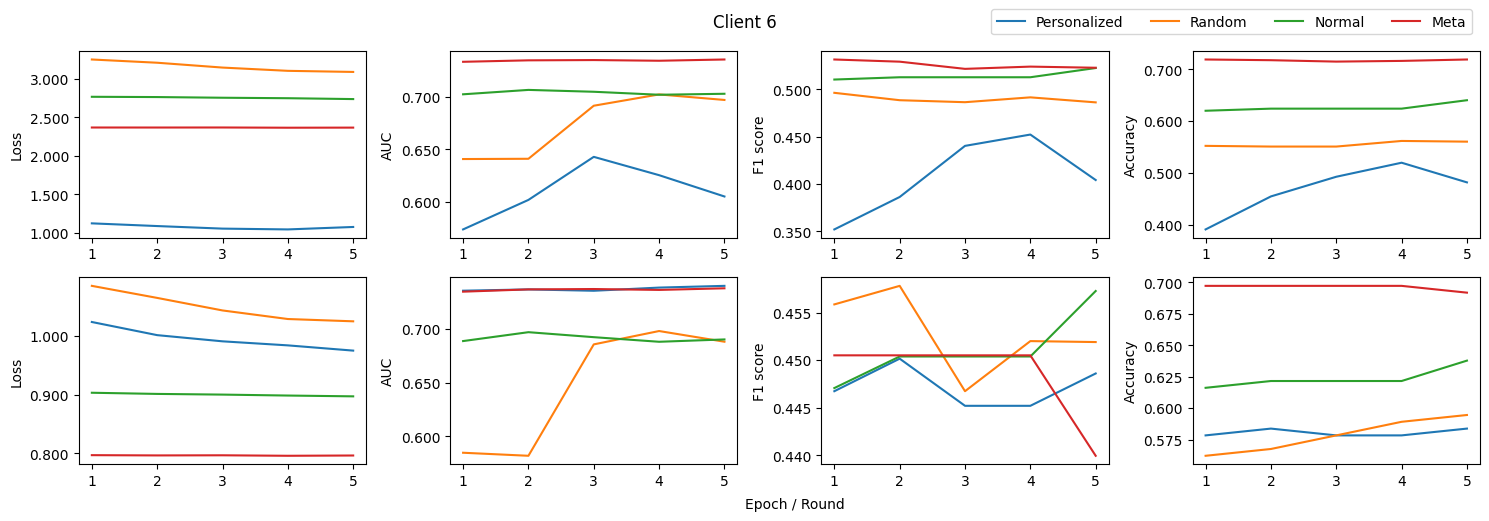

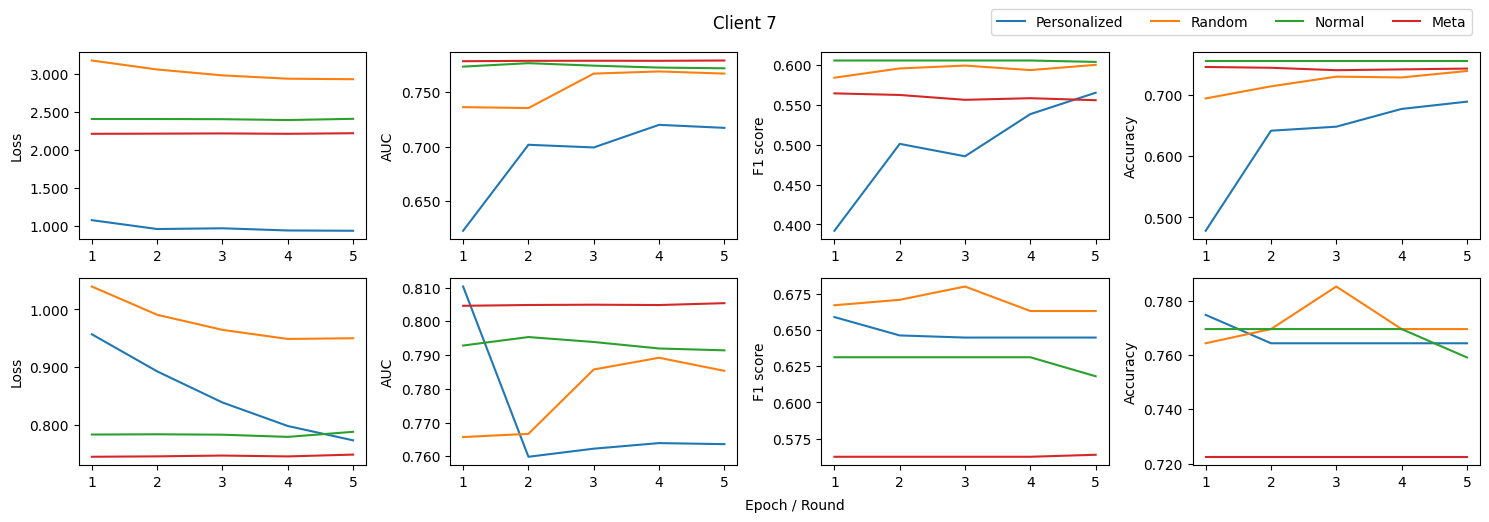

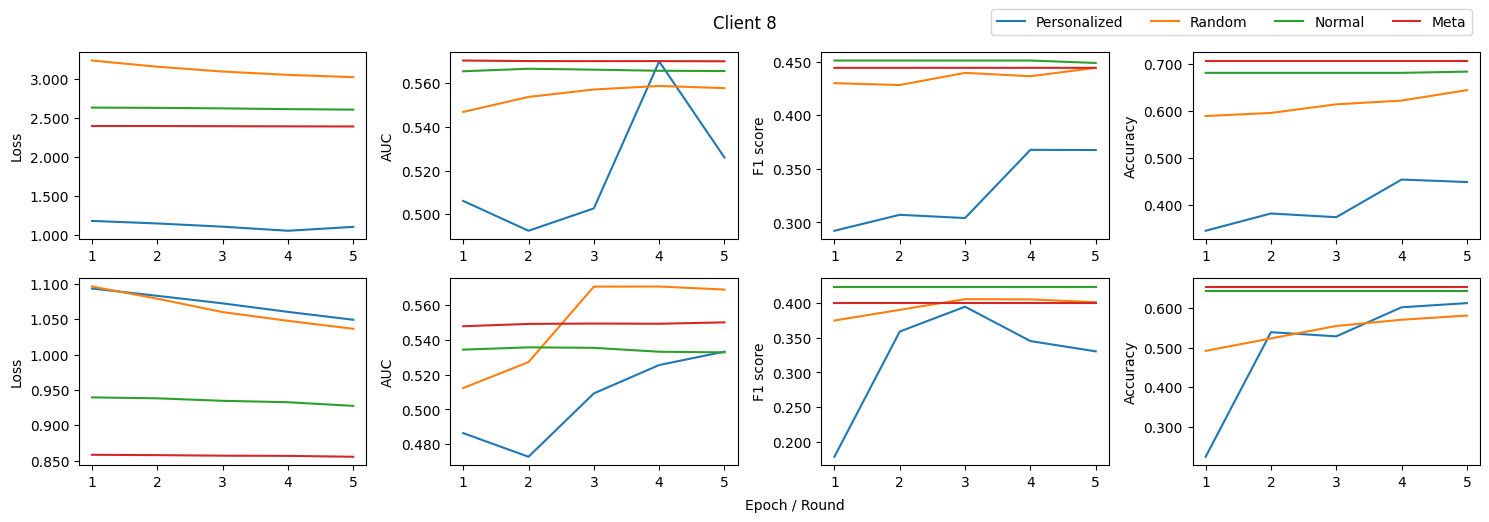

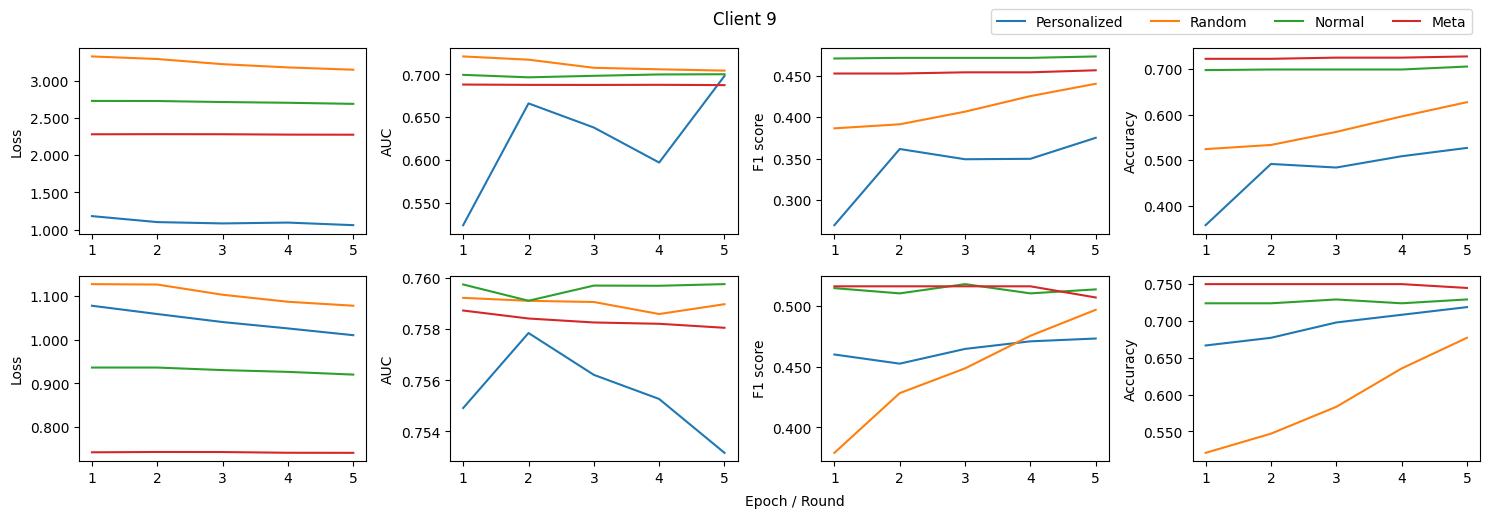

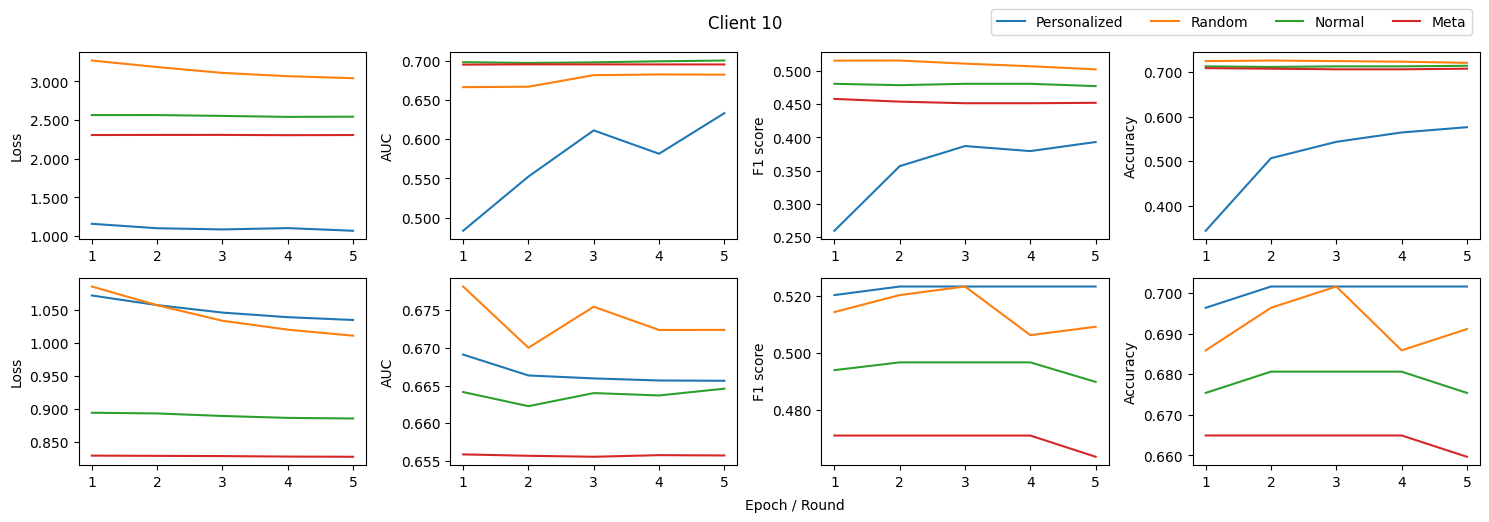

In [10]:
best_rounds_dic = {"random": [], "normal": [], "meta": [], "personalized": [],}

for client_idx in range(10):
    
    fig, ax = plt.subplots(2,4, figsize=(15,5),)
    
    for train_test_idx in range(2):
        
        learning_curve_1 = clients_results_random[client_idx][train_test_idx]["loss"][:want_round+1]
        auc_curve_1 = clients_results_random[client_idx][train_test_idx]["auc"][:want_round+1]
        f1_curve_1 = clients_results_random[client_idx][train_test_idx]["f1"][:want_round+1]
        acc_curve_1 = clients_results_random[client_idx][train_test_idx]["acc"][:want_round+1]
        kappa_curve_1 = clients_results_random[client_idx][train_test_idx]["kappa"][:want_round+1]
        
        learning_curve_2 = clients_results_normal[client_idx][train_test_idx]["loss"][:want_round+1]
        auc_curve_2 = clients_results_normal[client_idx][train_test_idx]["auc"][:want_round+1]
        f1_curve_2 = clients_results_normal[client_idx][train_test_idx]["f1"][:want_round+1]
        acc_curve_2 = clients_results_normal[client_idx][train_test_idx]["acc"][:want_round+1]
        kappa_curve_2 = clients_results_normal[client_idx][train_test_idx]["kappa"][:want_round+1]
        
        learning_curve_3 = clients_results_meta[client_idx][train_test_idx]["loss"][:want_round+1]
        auc_curve_3 = clients_results_meta[client_idx][train_test_idx]["auc"][:want_round+1]
        f1_curve_3 = clients_results_meta[client_idx][train_test_idx]["f1"][:want_round+1]
        acc_curve_3 = clients_results_meta[client_idx][train_test_idx]["acc"][:want_round+1]
        kappa_curve_3 = clients_results_meta[client_idx][train_test_idx]["kappa"][:want_round+1]

        local_learning_curve = local_result[train_test_idx][client_idx]["loss"][:want_round]
        local_auc_curve = local_result[train_test_idx][client_idx]["auc"][:want_round]
        local_f1_curve = local_result[train_test_idx][client_idx]["f1"][:want_round]
        local_acc_curve = local_result[train_test_idx][client_idx]["acc"][:want_round]

        ax[train_test_idx][0].plot(local_learning_curve, label="Personalized")    
        ax[train_test_idx][0].plot(learning_curve_1, label="Random")
        ax[train_test_idx][0].plot(learning_curve_2, label="Normal")
        ax[train_test_idx][0].plot(learning_curve_3, label="Meta")
        
        ax[train_test_idx][1].plot(local_auc_curve, label="Personalized")
        ax[train_test_idx][1].plot(auc_curve_1, label="Random")
        ax[train_test_idx][1].plot(auc_curve_2, label="Normal")
        ax[train_test_idx][1].plot(auc_curve_3, label="Meta")

        ax[train_test_idx][2].plot(local_f1_curve, label="Personalized")        
        ax[train_test_idx][2].plot(f1_curve_1, label="Random")
        ax[train_test_idx][2].plot(f1_curve_2, label="Normal")
        ax[train_test_idx][2].plot(f1_curve_3, label="Meta")
        
        ax[train_test_idx][3].plot(local_acc_curve, label="Personalized")
        ax[train_test_idx][3].plot(acc_curve_1, label="Random")
        ax[train_test_idx][3].plot(acc_curve_2, label="Normal")
        ax[train_test_idx][3].plot(acc_curve_3, label="Meta")
        
        if train_test_idx == 0:
            fig.suptitle(f"(Train) Client {client_idx+1}")
            
        else:
            fig.suptitle(f"(Test) Client {client_idx+1}")
            best_rounds_dic["personalized"].append(np.where(local_result[1][client_idx]["f1"] == np.max(local_result[1][client_idx]["f1"]))[0][0]) 
            best_rounds_dic["random"].append(np.where(clients_results_random[client_idx][1]["f1"] == np.max(clients_results_random[client_idx][1]["f1"]))[0][0]) 
            best_rounds_dic["normal"].append(np.where(clients_results_normal[client_idx][1]["f1"] == np.max(clients_results_normal[client_idx][1]["f1"]))[0][0])
            best_rounds_dic["meta"].append(np.where(clients_results_meta[client_idx][1]["f1"] == np.max(clients_results_meta[client_idx][1]["f1"]))[0][0])
        
        ax[train_test_idx][0].set_ylabel("Loss")
        ax[train_test_idx][1].set_ylabel("AUC")
        ax[train_test_idx][2].set_ylabel("F1 score")
        ax[train_test_idx][3].set_ylabel("Accuracy")

        ax[train_test_idx,0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax[train_test_idx,1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax[train_test_idx,2].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax[train_test_idx,3].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

        ax[train_test_idx,0].set_xticks(np.arange(0, want_round, 1), np.arange(1, want_round+1, 1))
        ax[train_test_idx,1].set_xticks(np.arange(0, want_round, 1), np.arange(1, want_round+1, 1))
        ax[train_test_idx,2].set_xticks(np.arange(0, want_round, 1), np.arange(1, want_round+1, 1))
        ax[train_test_idx,3].set_xticks(np.arange(0, want_round, 1), np.arange(1, want_round+1, 1))
    
    
    plt.suptitle(f"Client {client_idx+1}",)
    plt.tight_layout()

    fig.text(0.5, -0.01, "Epoch / Round",)
    plt.legend(loc=(-0.7, 2.3), ncol=4)
    plt.show()

In [11]:
# best_rounds_dic = {"random": {"acc":[], "f1":[], "auc":[]},
#                    "normal": {"acc":[], "f1":[], "auc":[]},
#                    "meta": {"acc":[], "f1":[], "auc":[]},
#                    "personalized": {"acc":[], "f1":[], "auc":[]},}

In [12]:
# best_rounds_dic = {"random": [],
#                    "normal": [],
#                    "meta": [],
#                    "personalized": [],}


# for client_idx in range(10):
#     best_rounds_dic["personalized"].append(np.where(local_result[1][client_idx]["f1"] == np.max(local_result[1][client_idx]["f1"]))[0][0]) 
#     best_rounds_dic["random"].append(np.where(clients_results_random[client_idx][1]["f1"] == np.max(clients_results_random[client_idx][1]["f1"]))[0][0]) 
#     best_rounds_dic["normal"].append(np.where(clients_results_normal[client_idx][1]["f1"] == np.max(clients_results_normal[client_idx][1]["f1"]))[0][0])
#     best_rounds_dic["meta"].append(np.where(clients_results_meta[client_idx][1]["f1"] == np.max(clients_results_meta[client_idx][1]["f1"]))[0][0])

In [15]:
best_performance = []

for client_idx in range(10):
        
    learning_curve_1 = clients_results_random[client_idx][1]["loss"][best_rounds_dic["random"][client_idx]]
    auc_curve_1 = clients_results_random[client_idx][1]["auc"][best_rounds_dic["random"][client_idx]]
    f1_curve_1 = clients_results_random[client_idx][1]["f1"][best_rounds_dic["random"][client_idx]]
    acc_curve_1 = clients_results_random[client_idx][1]["acc"][best_rounds_dic["random"][client_idx]]
    kappa_curve_1 = clients_results_random[client_idx][1]["kappa"][best_rounds_dic["random"][client_idx]]
    
    learning_curve_2 = clients_results_normal[client_idx][1]["loss"][best_rounds_dic["normal"][client_idx]]
    auc_curve_2 = clients_results_normal[client_idx][1]["auc"][best_rounds_dic["normal"][client_idx]]
    f1_curve_2 = clients_results_normal[client_idx][1]["f1"][best_rounds_dic["normal"][client_idx]]
    acc_curve_2 = clients_results_normal[client_idx][1]["acc"][best_rounds_dic["normal"][client_idx]]
    kappa_curve_2 = clients_results_normal[client_idx][1]["kappa"][best_rounds_dic["normal"][client_idx]]
    
    learning_curve_3 = clients_results_meta[client_idx][1]["loss"][best_rounds_dic["meta"][client_idx]]
    auc_curve_3 = clients_results_meta[client_idx][1]["auc"][best_rounds_dic["meta"][client_idx]]
    f1_curve_3 = clients_results_meta[client_idx][1]["f1"][best_rounds_dic["meta"][client_idx]]
    acc_curve_3 = clients_results_meta[client_idx][1]["acc"][best_rounds_dic["meta"][client_idx]]
    kappa_curve_3 = clients_results_meta[client_idx][1]["kappa"][best_rounds_dic["meta"][client_idx]]

    local_learning_curve = local_result[1][client_idx]["loss"][best_rounds_dic["personalized"][client_idx]]
    local_auc_curve = local_result[1][client_idx]["auc"][best_rounds_dic["personalized"][client_idx]]
    local_f1_curve = local_result[1][client_idx]["f1"][best_rounds_dic["personalized"][client_idx]]
    local_acc_curve = local_result[1][client_idx]["acc"][best_rounds_dic["personalized"][client_idx]]

    best_performance.append([[local_learning_curve, learning_curve_1, learning_curve_2, learning_curve_3],
                             [local_auc_curve, auc_curve_1, auc_curve_2, auc_curve_3],
                             [local_f1_curve, f1_curve_1, f1_curve_2, f1_curve_3],
                             [local_acc_curve, acc_curve_1, acc_curve_2, acc_curve_3]])

In [19]:
best_performance[0]

[[1.0500277280807495,
  0.9979277849197388,
  0.8671600818634033,
  0.8158968091011047],
 [array(0.6457581, dtype=float32),
  array(0.7001187, dtype=float32),
  array(0.68579197, dtype=float32),
  array(0.6720893, dtype=float32)],
 [0.45706579334446257,
  0.47660249477251426,
  0.4794685990338164,
  0.47819291819291826],
 [0.5495495495495496,
  0.5405405405405406,
  0.6666666666666666,
  0.7117117117117117]]